In [1]:
# hide
# default_exp model_fitting

from nbdev.showdoc import *

# CMR Benchmark

## Configuring the Parameter Search
To fit the model to some dataset, we select a cost function that scales against the likelihood that the model with a specified parameter configuration could have generated the specified dataset. Since our fitting functions are optimized on a per model basis, we need a unique one for CMR and this dataset.

In [2]:
# export
# hide

import numpy as np
from numba import njit
from numba.typed import List
from instance_cmr.models import CMR

@njit(fastmath=True, nogil=True)
def cmr_murd_likelihood(
    data_to_fit, item_counts, encoding_drift_rate, start_drift_rate, 
    recall_drift_rate, shared_support, item_support, learning_rate, 
    primacy_scale, primacy_decay, stop_probability_scale, 
    stop_probability_growth, choice_sensitivity):
    """
    Cost function for fitting the CMR model.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.
    
    **Arguments**:
    - trials: int64-array where rows identify a unique trial of responses and 
      columns corresponds to a unique recall index.  
    - A configuration for each parameter of `CMR`.
    
    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """
    
    result = 0.0
    for i in range(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        
        model = CMR(item_count, item_count, encoding_drift_rate, 
                    start_drift_rate, recall_drift_rate, shared_support,
                    item_support, learning_rate, primacy_scale, 
                    primacy_decay, stop_probability_scale, 
                    stop_probability_growth, choice_sensitivity)

        model.experience(np.eye(item_count, item_count))

        likelihood = np.ones((len(trials), item_count))

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recalling item with this index
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities(model.context)[recall]

                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        
        result -= np.sum(np.log(likelihood))
        
    return result

In [3]:
# export
# hide

def cmr_murd_objective_function(data_to_fit, fixed_parameters, free_parameters):
    """
    Configures cmr_likelihood for search over specified free/fixed parameters.
    """
    return lambda x: cmr_murd_likelihood(data_to_fit, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [4]:
try:
    show_doc(cmr_murd_likelihood, title_level=3)
    show_doc(cmr_murd_objective_function, title_level=3)
except:
    pass

<h3 id="cmr_murd_likelihood" class="doc_header"><code>cmr_murd_likelihood</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h3>

> <code>cmr_murd_likelihood</code>(**`data_to_fit`**, **`item_counts`**, **`encoding_drift_rate`**, **`start_drift_rate`**, **`recall_drift_rate`**, **`shared_support`**, **`item_support`**, **`learning_rate`**, **`primacy_scale`**, **`primacy_decay`**, **`stop_probability_scale`**, **`stop_probability_growth`**, **`choice_sensitivity`**)

Cost function for fitting the CMR model.

Output scales inversely with the likelihood that the model and specified 
parameters would generate the specified trials. For model fitting, is 
usually wrapped in another function that fixes and frees parameters for 
optimization.

**Arguments**:
- trials: int64-array where rows identify a unique trial of responses and 
  columns corresponds to a unique recall index.  
- A configuration for each parameter of [`CMR`](/instance_cmr/PrototypeCMR.html#CMR).

**Returns** the negative sum of log-likelihoods across specified trials 
conditional on the specified parameters and the mechanisms of InstanceCMR.

<h3 id="cmr_murd_objective_function" class="doc_header"><code>cmr_murd_objective_function</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h3>

> <code>cmr_murd_objective_function</code>(**`data_to_fit`**, **`fixed_parameters`**, **`free_parameters`**)

Configures cmr_likelihood for search over specified free/fixed parameters.

## Single-Subject Demo

Using these functions, we'll search for and visualize a parameter fit of the CMR model to a slice of data sampled from the classic Murdock (1962) study demonstrating the serial position curve, a pattern where early and later presented items tend to be recalled more often than middle items in a list-learning experiment. The data associated with the study is located at `data/MurdData_clean.mat`.

In [5]:
from instance_cmr.datasets import *

murd_trials0, murd_events0, murd_length0 = prepare_murddata(
    '../../../data/MurdData_clean.mat', 0)
print(murd_length0, np.shape(murd_trials0))

murd_events0.head()

20 (1200, 15)


,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


First, we'll make sure `cmr_murd_likelihood` returns valid values and has adequate performance.

In [6]:
lb = np.finfo(float).eps
hand_fit_parameters = {
    'item_counts': List([murd_length0]),
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}
cmr_murd_likelihood(List([murd_trials0[:80]]), **hand_fit_parameters)

1638.1388612098433

In [7]:
%%timeit
cmr_murd_likelihood(List([murd_trials0[:80]]), **hand_fit_parameters)

1.9 ms ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now we perform the single subject fitting...

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_murd_objective_function(
    List([murd_trials0[:80]]), 
    {'item_counts': List([murd_length0])}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

For the first subject in our murd_trials data structure, the function runs quickly returns an output with the following attributes:

```
     fun: 1443.7844998026485
 message: 'Optimization terminated successfully.'
    nfev: 9441
     nit: 56
 success: True
       x: array([0.58357356, 0.00943967, 0.66907882, 0.24216787, 0.97648943,
       0.08688427, 9.12889605, 1.79134438, 0.01805572, 0.34196481,
       4.87387628])
```

The `x` attribute of the result object contains the best parameter configuration found, while the `fun` attribute represents the overall cost of the configuration as computed with our specified cost function. 

We can visually compare the behavior of the model with these parameters against the data it's fitted to with a new
`visualize_fit` function.

In [17]:
# export
# hide

import pandas as pd
import seaborn as sns
from psifr import fr
import matplotlib.pyplot as plt

def visualize_fit(
    model_class, parameters, data, data_query=None, experiment_count=1000, savefig=False):
    """
    Apply organizational analyses to visually compare the behavior of the model 
    with these parameters against specified dataset.
    """
    
    # generate simulation data from model
    model = model_class(**parameters)
    try:
        model.experience(np.eye(model.item_count, model.item_count + 1, 1))
    except ValueError:
        model.experience(np.eye(model.item_count, model.item_count))
    sim = []
    for experiment in range(experiment_count):
        sim += [[experiment, 0, 'study', i + 1, i] for i in range(model.item_count)]
    for experiment in range(experiment_count):
        sim += [[experiment, 0, 'recall', i + 1, o] for i, o in enumerate(model.free_recall())]
    sim = pd.DataFrame(sim, columns=['subject', 'list', 'trial_type', 'position', 'item'])
    sim_data = fr.merge_free_recall(sim)
    
    # generate simulation-based spc, pnr, lag_crp
    sim_spc = fr.spc(sim_data).reset_index()
    sim_pfr = fr.pnr(sim_data).query('output <= 1') .reset_index()
    sim_lag_crp = fr.lag_crp(sim_data).reset_index()
    
    # generate data-based spc, pnr, lag_crp
    data_spc = fr.spc(data).query(data_query).reset_index()
    data_pfr = fr.pnr(data).query('output <= 1').query(data_query).reset_index()
    data_lag_crp = fr.lag_crp(data).query(data_query).reset_index()
    
    # combine representations
    data_spc['Source'] = 'Data'
    sim_spc['Source'] = model_class.__name__
    combined_spc = pd.concat([data_spc, sim_spc], axis=0)
    
    data_pfr['Source'] = 'Data'
    sim_pfr['Source'] = model_class.__name__
    combined_pfr = pd.concat([data_pfr, sim_pfr], axis=0)
    
    data_lag_crp['Source'] = 'Data'
    sim_lag_crp['Source'] = model_class.__name__
    combined_lag_crp = pd.concat([data_lag_crp, sim_lag_crp], axis=0)
    
    # generate plots of result
    # spc
    g = sns.FacetGrid(dropna=False, data=combined_spc)
    g.map_dataframe(sns.lineplot, x='input', y='recall', hue='Source')
    g.set_xlabels('Serial position')
    g.set_ylabels('Recall probability')
    plt.title('P(Recall) by Serial Position Curve')
    g.add_legend()
    g.set(ylim=(0, 1))
    if savefig:
        plt.savefig('figures/{}_fit_spc.jpeg'.format(model_class.__name__), bbox_inches='tight')
    else:
        plt.show()
    
    #pdf
    h = sns.FacetGrid(dropna=False, data=combined_pfr)
    h.map_dataframe(sns.lineplot, x='input', y='prob', hue='Source')
    h.set_xlabels('Serial position')
    h.set_ylabels('Probability of First Recall')
    plt.title('P(First Recall) by Serial Position')
    h.add_legend()
    h.set(ylim=(0, 1))
    if savefig:
        plt.savefig('figures/{}_fit_pfr.jpeg'.format(model_class.__name__), bbox_inches='tight')
    else:
        plt.show()
    
    # lag crp
    max_lag = 5
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    i = sns.FacetGrid(dropna=False, data=combined_lag_crp)
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_neg),
                                         x='lag', y='prob', hue='Source', **kws))
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_pos),
                                         x='lag', y='prob', hue='Source', **kws))
    i.set_xlabels('Lag')
    i.set_ylabels('Recall Probability')
    plt.title('Recall Probability by Item Lag')
    i.add_legend()
    i.set(ylim=(0, 1))
    if savefig:
        plt.savefig('figures/{}_fit_crp.jpeg'.format(model_class.__name__), bbox_inches='tight')
    else:
        plt.show()

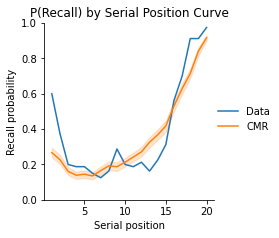

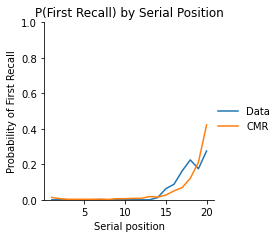

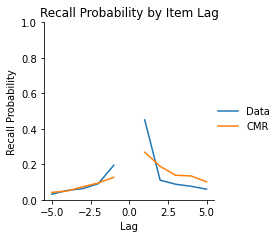

In [19]:
parameters = {
    'item_count':murd_length0,
    'presentation_count': murd_length0
}

visualize_fit(CMR, 
              {**parameters, 
               **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
              murd_events0, 'subject == 1', experiment_count=1000, savefig=True)